# Movie Recommendation System

In this notebook, I would like to create __movie recommendation system__ based on users' behaviors. __Collaborative filtering__ is one of the most efficient solutions to recommend people what movies they would like to watch. It analyzes what movies the current user has liked, finds other users who liked similar movies, and then recommend other movies that those users liked. By using collaborative filtering, we don't need to know anything about the movies' features like the years when they came out, genre, or preferred actors (or actress) in the movies. The only thing we care about in data is who like to watch movies. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data_MovieLens25M" data-toc-modified-id="Data_MovieLens25M-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data_MovieLens25M</a></span><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Creating-DataLoaders" data-toc-modified-id="Creating-DataLoaders-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating DataLoaders</a></span></li></ul></li><li><span><a href="#Probabilistic-matrix-factorization-(PMF)-approach" data-toc-modified-id="Probabilistic-matrix-factorization-(PMF)-approach-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Probabilistic matrix factorization (PMF) approach</a></span><ul class="toc-item"><li><span><a href="#Create-collaborative-filtering-from-scratch" data-toc-modified-id="Create-collaborative-filtering-from-scratch-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create collaborative filtering from scratch</a></span><ul class="toc-item"><li><span><a href="#n_factors=5" data-toc-modified-id="n_factors=5-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>n_factors=5</a></span></li><li><span><a href="#n_factors=50" data-toc-modified-id="n_factors=50-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>n_factors=50</a></span></li></ul></li><li><span><a href="#Interpreting-Biases" data-toc-modified-id="Interpreting-Biases-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Interpreting Biases</a></span></li><li><span><a href="#Interpreting-Embedding-matrices" data-toc-modified-id="Interpreting-Embedding-matrices-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Interpreting Embedding matrices</a></span></li><li><span><a href="#Interpreting-Embedding-Distance" data-toc-modified-id="Interpreting-Embedding-Distance-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Interpreting Embedding Distance</a></span></li></ul></li><li><span><a href="#Deep-Learning-for-Collaborative-Filtering" data-toc-modified-id="Deep-Learning-for-Collaborative-Filtering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Deep Learning for Collaborative Filtering</a></span><ul class="toc-item"><li><span><a href="#Deep-Learning-from-Scracth" data-toc-modified-id="Deep-Learning-from-Scracth-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Deep Learning from Scracth</a></span></li><li><span><a href="#Deep-learning-using-collab_learner" data-toc-modified-id="Deep-learning-using-collab_learner-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Deep learning using collab_learner</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Data_MovieLens25M

### Import

I used MovieLens-25M dataset provided by GroupLen Research [http://movielens.org]. They have collected available rating data sets about movies with 25 million ratings and one million tag applications applied to 62,000 movies by 162,000 users. 

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

import os
os.getcwd()

'/home/ubuntu/projects'

In [2]:
from IPython.display import Audio

In [3]:
path_s = Path('/home/ubuntu/Data/')
sound = path_s/'alert.mp3'

In [4]:
path = Path('/home/ubuntu/Data/ml_250m/')
Path.BASE_PATH = path
path.ls()

(#2) [Path('movies.csv'),Path('ratings.csv')]

In [5]:
fnames = ['movies', 'ratings']
tables = [pd.read_csv(path/f'{fname}.csv', low_memory=False) for fname in fnames]
movies, ratings = tables
movies.shape, ratings.shape

((62423, 3), (25000095, 4))

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [8]:
ratings['rating'].min(), ratings['rating'].max()

(0.5, 5.0)

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


I needed to merge the ratings with movies' tables to get the titles of movies.

In [10]:
def merge_tables(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                     suffixes=('', suffix))

In [11]:
ratings = merge_tables(ratings, movies, 'movieId')

In [12]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


### Creating DataLoaders

When showing the data, I prefer to see movie titles than its IDs because it is easy to interpret the results. By default, fastai dataloaders take the first column for the user (`userId`), the second column for the item (`movieId`), and the third column for the `ratings`, but I changed the value of `item_name` to use the movie `titles`

In [13]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64) 
dls.show_batch()

,userId,title,rating
0,83429,Dumb & Dumber (Dumb and Dumber) (1994),3.0
1,16693,About a Boy (2002),4.0
2,106353,Bulworth (1998),4.0
3,90728,Bad Santa (2003),5.0
4,156106,"Godfather, The (1972)",5.0
5,138114,Star Wars: Episode III - Revenge of the Sith (2005),3.0
6,102708,"Godfather: Part III, The (1990)",4.0
7,145241,Austin Powers in Goldmember (2002),3.0
8,149445,"Bourne Ultimatum, The (2007)",5.0
9,146592,Mom's Got a Date With a Vampire (2000),3.0


This can represent movies and user latent factor tables as simple matrices:

In [14]:
dls.classes

{'userId': (#162542) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#58959) ['#na#','"BLOW THE NIGHT!" Let\'s Spend the Night Together (1983)','"Great Performances" Cats (1998)','#1 Cheerleader Camp (2010)','#Captured (2017)','#Female Pleasure (2018)','#FollowMe (2019)','#Horror (2015)','#Lucky Number (2015)','#SCREAMERS (2016)'...]}

In [15]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
#n_factors = 5

#user_factors = torch.randn(n_users, n_factors)
#movie_factors = torch.randn(n_movies, n_factors)

In [18]:
# add this comment to alert when it completes the performance
Audio(sound, autoplay=True)

## Probabilistic matrix factorization (PMF) approach

The model for recommendation systems hease is based on probabilistic matrix factorization approach. There are three steps of this approach:

   1. Randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. 

   2. Calculate the predictions by taking the dot product of each movie with each user. 

   3. Calculate its loss. Here, I used _mean squared error_ because it represents the accuracy of a prediction. 


Using stochastic gradient descent (like minimizing the loss) helps the model optimize its parameters. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better. 

### Create collaborative filtering from scratch

This function makes __embedding__ which is multiplying by a one-hot-encoded matrix by using the computational shortcut that it can be implemented by simply indexing directly:

In [25]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

This is the collaborative filtering model:

In [26]:
class CollabModel(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

I tried to find out how many numbers of `n_factors` I need to choose for making a model to be better. So, I run the model with `n_factors=5` or `n_factors=50`.

At the beginning, this number doesn't mean anything since it was randomly chosen, but by the end of training, it will have meanings by learning on existing data about the relations between users and movies, without having any other information. The model still gets some important features. 


Also, I made this model to force predictions to be between 0 and 5 (which is rating's range) by setting `y_range`. 

#### n_factors=5

In [17]:
model_5 = CollabModel(n_users, n_movies, 5)

In [45]:
learn_5 = Learner(dls, model_5, loss_func=MSELossFlat())

In [ ]:
learn_5.model

Created learning rate graph to choose optimal learning rate for this model:

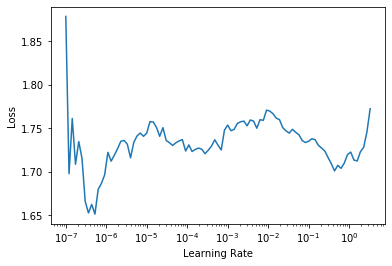

In [46]:
lr_min, ln_steep = learn_5.lr_find()

In [41]:
print(f'Minimum/10: {lr_min:.2e}, steepest point: {ln_steep:.2e}')

Minimum/10: 6.31e-08, steepest point: 1.58e-02


In [47]:
lr = 5e-3

Ready to fit the model! But in order to prevent overfitting, I needed to set weight decay (`wd=0.1`), as regularization, which consists in adding to its loss function the sum of all the weights squared. Since it computes the gradients, it will add a contribution to them that will encourage the weights to be as small as possible. Therefore, limiting the weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. 

In [48]:
# bs=64, n_factor=5
learn_5.fit_one_cycle(5, lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.983089,1.007022,53:05
1,1.012700,1.008605,53:05
2,0.996772,0.997366,52:49
3,0.983305,0.980212,52:55
4,1.009322,0.971833,52:37


In [50]:
learn_5.save('ml-25m-n5')

Path('models/ml-250m-stage1.pth')

#### n_factors=50

Tried to do the same performance with high `n_factors=50`

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64) 
dls.show_batch()

In [ ]:
dls.classes

In [ ]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])

In [27]:
model_50 = CollabModel(n_users, n_movies, 50)

In [28]:
learn_50 = Learner(dls, model_50, loss_func=MSELossFlat())

In [ ]:
learn_50.model

Created learning rate graph to choose optimal learning rate for this model:

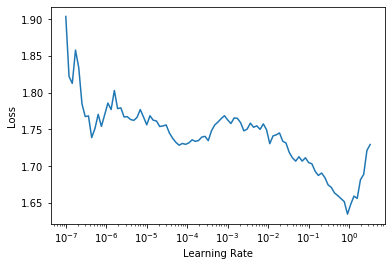

In [31]:
lr_min, lr_steep = learn_50.lr_find()

In [32]:
print(f'minimum/10: {lr_min: .2e}, steepest: {lr_steep: .2e}')

minimum/10:  9.12e-02, steepest:  1.58e-06


In [33]:
lr=1e-3

In [34]:
learn_50.fit_one_cycle(5, lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.958161,0.943539,52:13
1,0.935128,0.944161,52:07
2,0.922349,0.930718,52:37
3,0.901707,0.912431,53:37
4,0.897047,0.904213,52:58


As compared `n_factors=5` with `n_factors=50`, the model with high numbers performed better in this case. 

In [35]:
learn.save('ml-25m-n50')

Path('models/ml-250m-50-1.pth')

In [36]:
Audio(sound, autoplay=True)

### Interpreting Biases

It is useful to see what parameters the model has discovered. The easiest way to interpret is the biases. Here are the movies with the lowest values in the bias vector:

In [37]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:10]
[dls.classes['title'][i] for i in idxs]

['Battlefield Earth (2000)',
 'Speed 2: Cruise Control (1997)',
 'Batman & Robin (1997)',
 'Anaconda (1997)',
 'Super Mario Bros. (1993)',
 'Home Alone 3 (1997)',
 'Wild Wild West (1999)',
 'Spice World (1997)',
 'Grease 2 (1982)',
 'I Still Know What You Did Last Summer (1998)']

This says that even though users are very well matched to its latent factors (like age of movie, preferred actors or director, and so forth) for each of these movies, they will generally don't like it. The learned bias from the model tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy!

Here is the movies with the highest bias:

In [38]:
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'Godfather, The (1972)',
 "Schindler's List (1993)",
 'Fight Club (1999)',
 'Silence of the Lambs, The (1991)',
 'Pulp Fiction (1994)',
 'Godfather: Part II, The (1974)',
 'Matrix, The (1999)',
 "One Flew Over the Cuckoo's Nest (1975)"]

Therefore, for example, even if you don't normally like crime fiction movies, you might enjoy _Shawshank Redemption_!



### Interpreting Embedding matrices

It is not easy to directly interpret the embedding matrices, because there are too many factors for a human to look at. But by using __principal component analysis (PCA)__, we can pull out the most important underlying directions in such a matrix. 

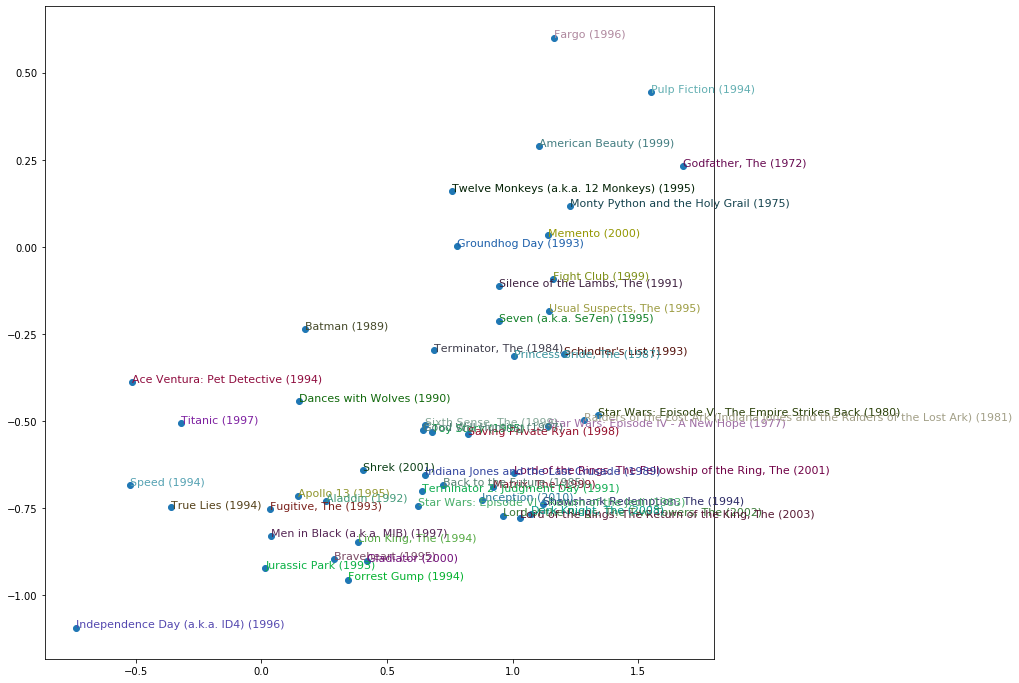

In [40]:
g = ratings.groupby('title')['rating'].count()

top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])

movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)

fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))

X = fac0[idxs]
Y = fac1[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X, Y)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
    
plt.show()

### Interpreting Embedding Distance

In [26]:
learn.load('/home/ubuntu/projects/models/ml-250m-50-1')

If there were two movies that were nearly identical, then their embedding vectors would also have to nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to _Silence of the Lambs_ :

In [40]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Forrest Gump (1994)'

In [41]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Fight Club (1999)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Ballad of Jack and Rose, The (2005)'

In [42]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Shawshank Redemption, The (1994)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Lidice (2011)'

In [43]:
movie_factors = learn.model.movie_factors
idx = dls.classes['title'].o2i['Matrix, The (1999)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'The Foreigner (2017)'

## Deep Learning for Collaborative Filtering

I can create and train a collaborative filtering model by using fastai's `collab_learner`. But this time, I used deep learning for collaborative filtering. 

### Deep Learning from Scracth

Here, I chose `n_factors=5`, because when I choose high numbers, the kernel would be dead so easily....

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64) 
dls.show_batch()

In [ ]:
dls.classes

In [ ]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])

In [18]:
learn_nn = collab_learner(dls, n_factors=5, y_range=(0, 5.5))

In [19]:
learn_nn.model

EmbeddingDotBias(
  (u_weight): Embedding(162542, 5)
  (i_weight): Embedding(56644, 5)
  (u_bias): Embedding(162542, 1)
  (i_bias): Embedding(56644, 1)
)

fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for the data. 

In [21]:
embs = get_emb_sz(dls)
embs

[(162542, 600), (56644, 600)]

In [22]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [48]:
model = CollabNN(*embs)

`CollabNN` creates `Embedding` layers in the same way as the previous class, except that it now uses the `embs` sizes.

In [ ]:
#learn_nn = Learner(dls, model_nn, loss_func=MSELossFlat())
#learn_nn.fit_one_cycle(5, 5e-3, wd=0.01)

### Deep learning using collab_learner

Even though I can create my own `CollabNN` to train a model, I used fastai's `colla_learner` and create two hidden layesr, of size 100 and 50 respectively:

In [24]:
learn_nn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])

In [25]:
learn_nn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(162542, 600)
    (1): Embedding(56644, 600)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

In [27]:
learn_nn.fit_one_cycle(3, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.957206,0.922794,2:17:49
1,0.878138,0.878575,2:18:36
2,0.711211,0.713233,2:17:54


We can see the train and validation loss got better than the previous models, but it took much more time to train a model. 

In [29]:
learn.save('ml-25m-nn')

Path('models/ml-250m-dp.pth')

## Conclusion

I created movie recommendation system by using collaborative filtering technique. This model can be useful when we recommend someone who like to watch particular movies depending on other users who have similar tastes. 